In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import ssl
import re
import warnings
import matplotlib.pyplot as plt

In [476]:
#Does a value investing framework work? 
data = yf.download("SPY AAPL", start="2017-01-01", end="2017-04-30")

[*********************100%***********************]  2 of 2 completed


In [478]:
msft = yf.Ticker("MSFT")

In [481]:
msft.quarterly_financials

,2022-03-31,2021-12-31,2021-09-30,2021-06-30
Research Development,6306000000.0,5758000000.0,5599000000.0,5687000000.0
Effect Of Accounting Charges,None,None,None,None
Income Before Tax,20190000000.0,22515000000.0,20524000000.0,19405000000.0
Minority Interest,None,None,None,None
Net Income,16728000000.0,18765000000.0,20505000000.0,16458000000.0
Selling General Administrative,7075000000.0,6763000000.0,5834000000.0,7379000000.0
Gross Profit,33745000000.0,34768000000.0,31671000000.0,32161000000.0
Ebit,20364000000.0,22247000000.0,20238000000.0,19095000000.0
Operating Income,20364000000.0,22247000000.0,20238000000.0,19095000000.0
Other Operating Expenses,None,None,None,None


In [38]:
ssl._create_default_https_context = ssl._create_unverified_context

In [354]:
#Define metrics

def CAGR(data, interval='daily'):
    data['cum return'] = (1 + data["return"]).cumprod()
    length = 365
    if interval == 'month':
        length = 12
    elif interval == 'year':
        length = 1
    n = len(data)/length
    CAGR = (data['cum return'].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(data):
    vol = data['return'].std() * np.sqrt(12)
    return vol
    
def sharpe(data, rf):
    sharpe = (CAGR(data) - rf)/volatility(data)
    return sharpe

def max_dd(data):
    data['cum return'] = (1 + data['return']).cumprod()
    data['cum roll max'] = df['cum return'].cummax()
    data['drawdown'] = df['cum roll max'] - data['cum return']
    data['drawdown percentage'] = data['drawdown'] / data['cum roll max']
    max_draw = data['drawdown percentage'].max()
    return max_draw

In [432]:
#Pulling Damodaran's Data
def load_data(path):
    warnings.simplefilter(action='ignore', category=UserWarning)
    return pd.ExcelFile(path)

def damodarandata():
    xls = load_data('https://pages.stern.nyu.edu/~adamodar/pc/implprem/ERPbymonth.xlsx')
    df = pd.read_excel(xls, 'Historical ERP')
    df['Start of month'] = df['Start of month'] - pd.Timedelta(1, unit='D')
    df = df.T
    new_header = df.iloc[0]
    df = df[1:]
    df.columns = new_header
    df = df.T
    df['T.Bond Rate'] = df['T.Bond Rate'].replace({',':'.'}, regex=True)
    return df[['T.Bond Rate','ERP (T12m)']]


In [448]:
def costofdebt(ebit, riskfree, interestpayment):
    if isinstance(riskfree, str) and '%' in riskfree:
        riskfree = float(riskfree.replace('%',""))/100
    try:
        interestcoverage = ebit/interestpayment
    except ZeroDivisionError:
        interestcoverage = 10
    finally:
        default = 0
        if interestcoverage >= 8.5 or interestcoverage == np.nan:
            default = 0.0075
        elif interestcoverage >= 6.5 and interestcoverage < 8.5:
            default = .01
        elif interestcoverage >= 5.5 and interestcoverage < 6.5:
            default = 0.015
        elif interestcoverage >= 4.25 and interestcoverage < 5.5:
            default = 0.018
        elif interestcoverage >= 3 and interestcoverage < 4.25:
            default = 0.02
        elif interestcoverage >= 2.5 and interestcoverage < 3:
            default = 0.0225
        elif interestcoverage >= 2.25 and interestcoverage < 2.5:
            default = 0.0275
        elif interestcoverage >= 2 and interestcoverage < 2.25:
            default = 0.035
        elif interestcoverage >= 1.75 and interestcoverage < 2:
            default = 0.0475
        elif interestcoverage >= 1.5 and interestcoverage < 1.75:
            default = 0.065
        elif interestcoverage >= 1.25 and interestcoverage < 1.5:
            default = 0.080
        elif interestcoverage >= 0.8 and interestcoverage < 1.25:
            default = 0.1
        elif interestcoverage >= 0.65 and interestcoverage < 0.8:
            default = 0.115
        elif interestcoverage >= 0.2 and interestcoverage < 0.65:
            default = 0.127
        elif interestcoverage < 0.2:
            default = 0.15
        return default + riskfree

def costofequity(beta, riskfree, riskprem):
    if isinstance(riskfree, str) and '%' in riskfree:
        riskfree = float(riskfree.replace('%',""))/100
    return riskfree + beta*riskprem

def WACC(totaldebt, totalequity, costequity, costdebt, beta, taxrate=0.21):
    
    wacc = costdebt * (1 - taxrate) * (totaldebt / (totalequity + totaldebt)) + costequity * (totalequity / (totalequity + totaldebt))
    
    return wacc

In [428]:
def OperatingMargin(EBIT, Revenue):
    return round(EBIT/Revenue,3)

def balancesheet(ticker):
    data = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=Q&section=Balance%20Sheet&sort=desc".format(ticker)
    balance_original = pd.read_excel(data, engine='openpyxl')
    
    balance = balance_original.T
    new_header = balance.iloc[0]
    balance = balance[1:]
    balance.columns = new_header
    
    balance = balance[['Cash and Short Term Investments', 'Shareholders Equity (Total)', 'Total Debt', 'Shares (Common)']]
    
    return balance
    
def incomestatement(ticker):
    data = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=Q&section=Income%20Statement&sort=desc".format(ticker)
    income_original = pd.read_excel(data, engine='openpyxl')
    
    columns = ['Revenue','Operating Income', 'Interest Expense (Operating)',
                          'Non-operating Interest Expenses','Income Tax Provision']
    
    income = income_original.T
    new_header = income.iloc[0]
    income = income[1:]
    income.columns = new_header
    
    for col in columns:
        if col not in income.columns:
            income[col] = 0
    
    income = income[['Revenue','Operating Income', 'Interest Expense (Operating)',
                          'Non-operating Interest Expenses','Income Tax Provision']]
    
    income = income[::-1].rolling(4).sum().dropna(how='all').fillna(0)
    
    income['EBIT Margin'] = np.vectorize(OperatingMargin)(income['Operating Income'], income['Revenue'])
    income['Interest'] = income['Interest Expense (Operating)'] + income['Non-operating Interest Expenses']
    
    growth_rate = income['Revenue'].pct_change(1)
    growth_rate.rename('Revenue YoY Growth', inplace=True)
    average_growth_rate = growth_rate.rolling(3).mean()
    average_growth_rate.rename('Average Revenue Growth', inplace=True)
    average_EBIT = income['EBIT Margin'].rolling(3).mean()
    average_EBIT.rename('Average EBIT Margin', inplace=True)
    
    combined_income = pd.concat([income, growth_rate, average_growth_rate, average_EBIT], axis=1)
    
    return combined_income

def ROIC(totaldebt, totalequity, cash, EBIT, taxrate=0.21):
    return EBIT*(1-taxrate)/(totaldebt + totalequity - cash)

def freecashflow(Revenue, EBITMargin, ROIC, growth, WACC, ltgrowth, time=3, taxrate=0.21):
    if ROIC == 0 or ROIC is np.nan:
        ROIC = 0.1
    if isinstance(ltgrowth, str) and '%' in ltgrowth:
        ltgrowth = float(ltgrowth.replace('%',""))/100
    freecashannuity = ((Revenue*EBITMargin*(1-taxrate) * (1 - growth/ROIC))/(WACC - growth))*(1 - ((1+growth)/(1+WACC))**time)
    terminalvalue = (Revenue*EBITMargin*(1-taxrate) * (1 - growth/ROIC))*(1+growth)**time/(WACC - ltgrowth)
    return freecashannuity + terminalvalue

def financialstatement(ticker, stockreturns, marketreturns, equitydata):
    balance_sheet = balancesheet(ticker)
    income_statement = incomestatement(ticker)
    
    combined_fs = pd.concat([balance_sheet, income_statement], axis=1)
    combined_fs.index.name = 'date'      
    equitydata.index.name = 'date'
    
    combined_fs = pd.merge(combined_fs, equitydata, left_index=True, right_index=True)
    combined_fs.reset_index(inplace=True)
    combined_fs.dropna(inplace=True)
                     
    combined_fs['date_calculation'] = combined_fs['date'].astype(str)
    combined_fs['Beta'] = yf.Ticker(ticker).info['beta']
    
    combined_fs['CostofDebt'] = np.vectorize(costofdebt)(combined_fs['Operating Income'], combined_fs['T.Bond Rate'], combined_fs['Interest'])
    combined_fs['CostofEquity'] = np.vectorize(costofequity)(combined_fs['Beta'], combined_fs['T.Bond Rate'], combined_fs['ERP (T12m)'])
    combined_fs['WACC'] = np.vectorize(WACC)(combined_fs['Total Debt'], combined_fs['Shareholders Equity (Total)'], 
                                             combined_fs['CostofEquity'], combined_fs['CostofDebt'], combined_fs['Beta'])
    
    combined_fs['ROIC'] = np.vectorize(ROIC)(combined_fs['Total Debt'], combined_fs['Shareholders Equity (Total)'],
                                            combined_fs['Cash and Short Term Investments'], combined_fs['Operating Income'])
                     
    combined_fs['freecashflow'] = np.vectorize(freecashflow)(combined_fs['Revenue'], combined_fs['Average EBIT Margin'], 
                                                             combined_fs['ROIC'], combined_fs['Average Revenue Growth'],
                                                            combined_fs['WACC'], combined_fs['T.Bond Rate'])
    

    combined_fs.drop(columns=['date_calculation'], inplace=True)
    
    combined_fs['date'] = combined_fs['date'] + pd.Timedelta(1, unit='D') 
    combined_fs['date'] = combined_fs['date'] + pd.DateOffset(months=1)
    
    combined_fs.set_index('date',inplace=True)
    
    return combined_fs

In [429]:
tickers = ['NKE','PG','CRM','TRV','UNH','VZ','V','WBA','WMT']

In [451]:
def damodaran_data():
    damodata = pd.read_csv(r'ERP-TBonds.csv')
    damodata['Start of month'] = pd.to_datetime(damodata['Start of month'])
    damodata.set_index('Start of month', inplace=True)
    return damodata

In [453]:
ohlc_mon = {}
start = dt.datetime.today() - dt.timedelta(3650)
end = dt.datetime.today()
damodata = damodaran_data()
market_ticker = 'SPY'

market = yf.download(market_ticker, start, end, interval='1mo')

for ticker in tickers:
    print(ticker)
    ohlc_mon[ticker] = yf.download(ticker, start, end, interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True, how='all')
    financial_data = financialstatement(ticker=ticker, stockreturns=ohlc_mon[ticker], marketreturns = market, equitydata=damodata)
    ohlc_mon[ticker] = ohlc_mon[ticker].merge(AAPL_fs_data, how='left', left_index=True, right_index=True)
    ohlc_mon[ticker].fillna(method='ffill',inplace=True)
    ohlc_mon[ticker]['Return'] = ohlc_mon[ticker]['Adj Close'].pct_change()
    ohlc_mon[ticker]['Market Capitalization'] = ohlc_mon[ticker]['Shares (Common)'] * ohlc_mon[ticker]['Adj Close']
    ohlc_mon[ticker]['FV Difference Per Share'] = (ohlc_mon[ticker]['freecashflow'] - ohlc_mon[ticker]['Market Capitalization'])/ ohlc_mon[ticker]['Shares (Common)']
    
tickers = ohlc_mon.keys()

[*********************100%***********************]  1 of 1 completed
NKE
[*********************100%***********************]  1 of 1 completed
PG
[*********************100%***********************]  1 of 1 completed
CRM
[*********************100%***********************]  1 of 1 completed


C:\Users\user\anaconda3\envs\Scrapy_Django_Plotly\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


TRV
[*********************100%***********************]  1 of 1 completed
UNH
[*********************100%***********************]  1 of 1 completed
VZ
[*********************100%***********************]  1 of 1 completed
V
[*********************100%***********************]  1 of 1 completed
WBA
[*********************100%***********************]  1 of 1 completed
WMT
[*********************100%***********************]  1 of 1 completed


In [459]:
new_ohlc = copy.deepcopy(ohlc_mon)

In [460]:
dataframe = pd.DataFrame()

for ticker in tickers:
    dataframe[f'{ticker}-return'] = new_ohlc[ticker]['Return']
    dataframe[f'{ticker}-FVDiff'] = new_ohlc[ticker]['FV Difference Per Share']

In [461]:
dataframe[dataframe.isna().any(axis=1)]

,NKE-return,NKE-FVDiff,PG-return,PG-FVDiff,CRM-return,CRM-FVDiff,TRV-return,TRV-FVDiff,UNH-return,UNH-FVDiff,VZ-return,VZ-FVDiff,V-return,V-FVDiff,WBA-return,WBA-FVDiff,WMT-return,WMT-FVDiff
Date,,,,,,,,,,,,,,,,,,
2012-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-09-01,-0.021595,NaN,0.032296,NaN,0.051729,NaN,0.054371,NaN,0.020442,NaN,0.061248,NaN,0.048794,NaN,0.026924,NaN,0.022026,NaN
2012-10-01,-0.037193,NaN,-0.001730,NaN,-0.043945,NaN,0.046723,NaN,0.014741,NaN,-0.020408,NaN,0.033363,NaN,-0.033205,NaN,0.016532,NaN
2012-11-01,0.066754,NaN,0.016803,NaN,0.080079,NaN,-0.001692,NaN,-0.028750,NaN,-0.000760,NaN,0.078913,NaN,-0.037468,NaN,-0.039990,NaN
2012-12-01,0.058679,NaN,-0.027782,NaN,0.066151,NaN,0.014121,NaN,-0.002758,NaN,-0.019266,NaN,0.014842,NaN,0.100334,NaN,-0.052624,NaN
2013-01-01,0.052004,NaN,0.107086,NaN,0.023974,NaN,0.099286,NaN,0.021941,NaN,0.007858,NaN,0.041760,NaN,0.079708,NaN,0.030898,NaN
2013-02-01,0.007586,NaN,0.021788,NaN,-0.016906,NaN,0.024981,NaN,-0.031878,NaN,0.079396,NaN,0.004623,NaN,0.024525,NaN,0.011865,NaN
2013-03-01,0.087751,NaN,0.011552,NaN,0.056790,NaN,0.046879,NaN,0.070346,NaN,0.056308,NaN,0.072858,NaN,0.172316,NaN,0.057220,NaN
2013-04-01,0.077783,NaN,-0.003763,NaN,-0.080467,NaN,0.020252,NaN,0.051610,NaN,0.096846,NaN,-0.008125,NaN,0.038381,NaN,0.045322,NaN


In [462]:
dataframe = dataframe.dropna()

In [463]:
def port(dataframe, m, x):
    portfolio = []
    return_cal = [0]
    
    dataframe = dataframe[dataframe['Date'] >= '2014-05-01']
    print(dataframe.shape)
    
    for i in range(99):
        if len(portfolio) > 0:
            return_cal.append(dataframe[['{}-return'.format(holding) for holding in portfolio]].iloc[i,:].mean())
            sell_selection = dataframe.filter(regex='[A-Za-z]+-FVDiff', axis=1).iloc[i,].sort_values(ascending=True)[:x].index.values.tolist()
            bad_stocks = [re.search('.+?(?=-)', t).group(0) for t in sell_selection]
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        buy_selection = dataframe.filter(regex='[A-Za-z]+-FVDiff', axis=1).iloc[i,:].sort_values(ascending=False, na_position='last')[:fill].index.values.tolist()
        if len(buy_selection) != 0:
            good_stocks = [re.search('.+?(?=-)', t).group(0) for t in buy_selection]
            portfolio = portfolio + good_stocks
    port_returns = pd.DataFrame(np.array(return_cal), columns=['return'])
    return port_returns

In [471]:
dataframe.reset_index(inplace=True)

In [472]:
dataframe

,Date,NKE-return,NKE-FVDiff,PG-return,PG-FVDiff,CRM-return,CRM-FVDiff,TRV-return,TRV-FVDiff,UNH-return,UNH-FVDiff,VZ-return,VZ-FVDiff,V-return,V-FVDiff,WBA-return,WBA-FVDiff,WMT-return,WMT-FVDiff
0,2014-05-01,0.054284,2.784672,-0.013501,-25.972809,0.018974,-14.638394,0.031685,-39.176445,0.061167,-32.064301,0.081027,3.570595,0.060313,-12.782070,0.059057,-19.323998,-0.036884,-25.926422
1,2014-06-01,0.011505,2.379619,-0.027231,-24.230999,0.103553,-20.088394,0.006634,-39.688408,0.026623,-33.929405,-0.020616,4.280224,-0.017324,-11.902455,0.035686,-21.369339,-0.016090,-24.897988
2,2014-07-01,-0.005416,2.572498,-0.016160,-23.225468,-0.065944,-16.258393,-0.042397,-36.394989,-0.003903,-33.648689,0.030451,3.253662,0.001424,-11.973480,-0.072305,-17.077240,-0.019848,-23.649765
3,2014-08-01,0.018411,4.297059,0.083470,-25.958636,0.089217,-18.721747,0.057503,-38.295825,0.069463,-36.248400,-0.001260,5.674077,0.007156,-9.954394,-0.119965,-8.094252,0.026094,-22.881583
4,2014-09-01,0.139011,-0.717246,0.007581,-26.461451,-0.026400,-17.161746,-0.008130,-37.656283,-0.004961,-35.868304,0.003412,5.555684,0.005913,-10.251941,-0.015292,-7.353164,0.019520,-24.116214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2022-03-01,-0.014574,209.734094,-0.019822,191.708413,0.008502,131.335931,0.063435,162.841225,0.071658,-163.002540,-0.050866,293.954057,0.027812,122.308694,-0.018844,299.405736,0.101805,195.846978
95,2022-04-01,-0.071161,219.264130,0.050720,184.001641,-0.171345,167.715936,-0.058949,173.499993,0.000167,-163.086921,-0.091088,298.481278,-0.038959,130.932214,-0.052937,301.748216,0.031304,191.220025
96,2022-05-01,-0.046913,216.727520,-0.073749,187.403782,-0.089235,175.043782,0.046650,157.190007,-0.023144,-159.730892,0.121264,284.631054,-0.004504,123.518238,0.033726,291.962670,-0.159226,207.119648
97,2022-06-01,-0.140093,233.336369,-0.027658,191.493794,0.029955,170.243794,-0.055351,167.047627,0.033918,-176.521022,-0.010528,285.164345,-0.070245,138.393788,-0.125138,297.383786,-0.051373,213.703785


In [473]:
CAGR(port(dataframe, 10, 1), 'month')

(99, 19)


0.10625020259272455

In [474]:
SPY = yf.download('^GSPC', '2014-05-01', re.search('\d\d\d\d-\d\d-\d\d', str(dataframe.tail(1)['Date'].values)).group(0), interval='1mo')
SPY['return'] = SPY['Adj Close'].pct_change().fillna(0)
CAGR(SPY, 'month')

[*********************100%***********************]  1 of 1 completed


0.08642607901580157

(99, 19)


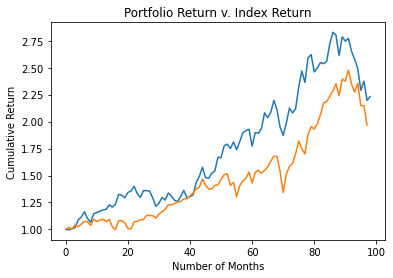

In [475]:
fig, ax = plt.subplots()
plt.plot((1+port(dataframe, 2, 1)).cumprod())
plt.plot((1+SPY['return'].reset_index(drop=True)).cumprod())
plt.title("Portfolio Return v. Index Return")
plt.ylabel("Cumulative Return")
plt.xlabel("Number of Months")
plt.show()